# MARKETING ANALYTICS - CHURN ANALYSIS

### Importing Necessary Libraraies

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data Imputing
from sklearn.impute import KNNImputer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
ecom = pd.read_csv("data/E-Commerce Churn Data.csv")

In [3]:
df = ecom.copy()
ecom.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


In [4]:
ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [5]:
# Percentage of Missing Values
round(ecom.isnull().sum()/ecom.shape[0] * 100, 2)

CustomerID                     0.00
Churn                          0.00
Tenure                         4.69
PreferredLoginDevice           0.00
CityTier                       0.00
WarehouseToHome                4.46
PreferredPaymentMode           0.00
Gender                         0.00
HourSpendOnApp                 4.53
NumberOfDeviceRegistered       0.00
PreferedOrderCat               0.00
SatisfactionScore              0.00
MaritalStatus                  0.00
NumberOfAddress                0.00
Complain                       0.00
OrderAmountHikeFromlastYear    4.71
CouponUsed                     4.55
OrderCount                     4.58
DaySinceLastOrder              5.45
CashbackAmount                 0.00
dtype: float64

### Data Cleaning

#### Categorical : Removing Duplicates

In [6]:
cat_cols = ecom.dtypes[ecom.dtypes == 'object'].index

for i in cat_cols:
    print(f"{i} ---> {ecom[i].unique()}")
    print()

PreferredLoginDevice ---> ['Mobile Phone' 'Phone' 'Computer']

PreferredPaymentMode ---> ['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']

Gender ---> ['Female' 'Male']

PreferedOrderCat ---> ['Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']

MaritalStatus ---> ['Single' 'Divorced' 'Married']



In [7]:
# Change values to lower and replace space with _ for cleaning
for i in cat_cols:
    ecom[i] = ecom[i].apply(lambda x: x.lower().replace(" ", "_"))

In [8]:
# Replacing duplicate values
ecom["PreferredLoginDevice"].replace("phone", "mobile_phone", inplace = True)
ecom["PreferredPaymentMode"].replace(["cc", "cod"], ["credit_card", "cash_on_delivery"], inplace = True)
ecom["PreferedOrderCat"].replace("mobile_phone", "mobile", inplace = True)

In [9]:
# Checking if all values are replaced
for i in cat_cols:
    print(f"{i} ---> {ecom[i].unique()}")
    print()

PreferredLoginDevice ---> ['mobile_phone' 'computer']

PreferredPaymentMode ---> ['debit_card' 'upi' 'credit_card' 'cash_on_delivery' 'e_wallet']

Gender ---> ['female' 'male']

PreferedOrderCat ---> ['laptop_&_accessory' 'mobile' 'others' 'fashion' 'grocery']

MaritalStatus ---> ['single' 'divorced' 'married']



#### Numerical : Imputing missing values using KNN Imputer

In [10]:
# Encoding before imputing missing values
ecom_encoded = pd.get_dummies(ecom, drop_first = True)

In [11]:
# Using KNN Imputer
impute = KNNImputer(n_neighbors = 5)
ecom_imputed = impute.fit_transform(ecom_encoded)

In [12]:
# Converting the imputed array to dataframe
ecom_imputed = pd.DataFrame(ecom_imputed, columns = ecom_encoded.columns)

In [13]:
# Replacing the old columns with imputed values for analysis
missing_cols = ecom.isnull().sum()[ecom.isnull().sum() > 0].index

for i in missing_cols:
    ecom[i] = ecom_imputed[i]

### EDA

**Percentage of Customers who Left**

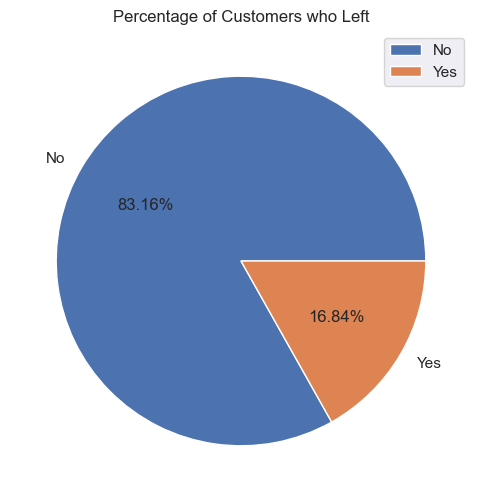

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [15,6])

percent_count = ecom['Churn'].value_counts(normalize = True)
ax.pie(x = ecom['Churn'].value_counts(),labels = ["No", "Yes"], autopct = lambda percent_count: '{:.2f}%'.format(percent_count))
ax.set_title('Percentage of Customers who Left', fontsize = 12)
ax.legend()

plt.show()

- 16% of customers left the company.

**Customer Churn by Gender**

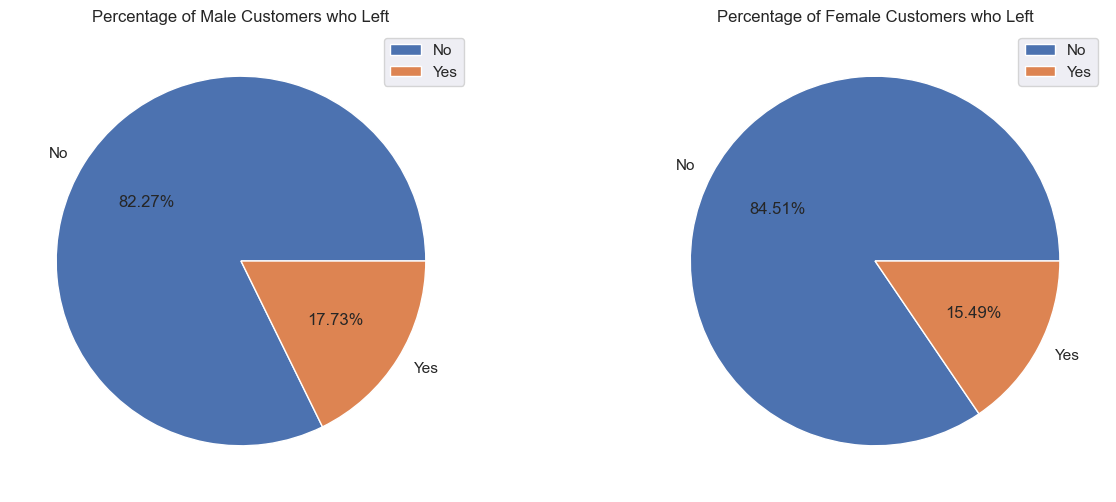

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = [15,6])

percent_count = ecom[ecom["Gender"] == "male"]['Churn'].value_counts(normalize = True)
ax1.pie(x = ecom[ecom["Gender"] == "male"]['Churn'].value_counts(),labels = ["No", "Yes"], autopct = lambda percent_count: '{:.2f}%'.format(percent_count))
ax1.set_title('Percentage of Male Customers who Left', fontsize = 12)
ax1.legend()

percent_count = ecom[ecom["Gender"] == "female"]['Churn'].value_counts(normalize = True)
ax2.pie(x = ecom[ecom["Gender"] == "female"]['Churn'].value_counts(),labels = ["No", "Yes"], autopct = lambda percent_count: '{:.2f}%'.format(percent_count))
ax2.set_title('Percentage of Female Customers who Left', fontsize = 12)
ax2.legend()

plt.show()

- Gender has no effect on churn since the percentage of males and females who left the company is almost same.

**Customer Churn by Tenure Range**

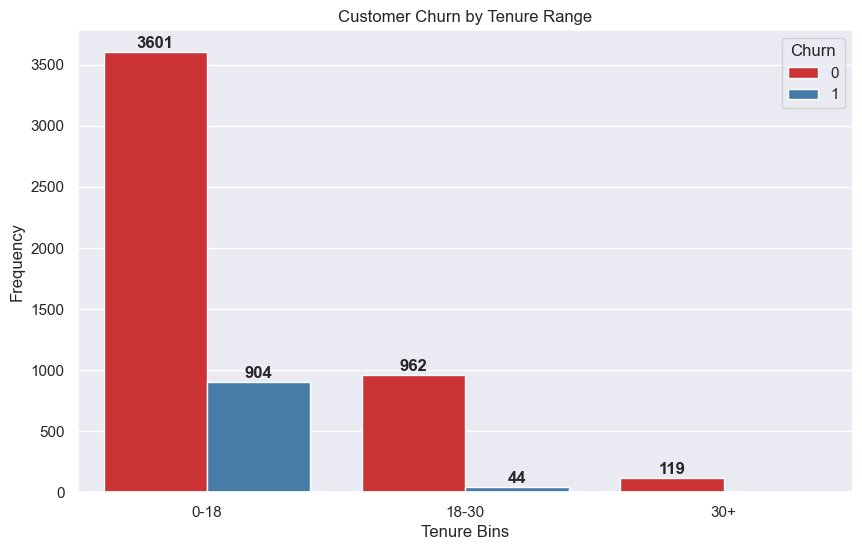

In [16]:
# Creating Tenure Groups
bins = [0, 18, 30, np.inf]
labels = ['0-18', '18-30', '30+']
ecom['TenureRange'] = pd.cut(ecom['Tenure'], bins = bins, labels = labels, right = False, include_lowest = True)

plt.figure(figsize=(10,6))
ax = sns.countplot(data = ecom, x = 'TenureRange', hue = 'Churn', palette = 'Set1')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha = 'center', va = 'baseline', 
                    xytext = (0, 3), weight = 'bold',
                    textcoords = 'offset points')

plt.title('Customer Churn by Tenure Range')
plt.xlabel('Tenure Bins')
plt.ylabel('Frequency')
plt.show()


- Most customers churned in the first 18 months may be due to the first impressions from the company.
- Long term customers tend to stay longer may be due to the service provided by the company.
- This indicates that the company should focus on giving more priority to new customers.

**Average Estimated Monthly Spending by Tenure**

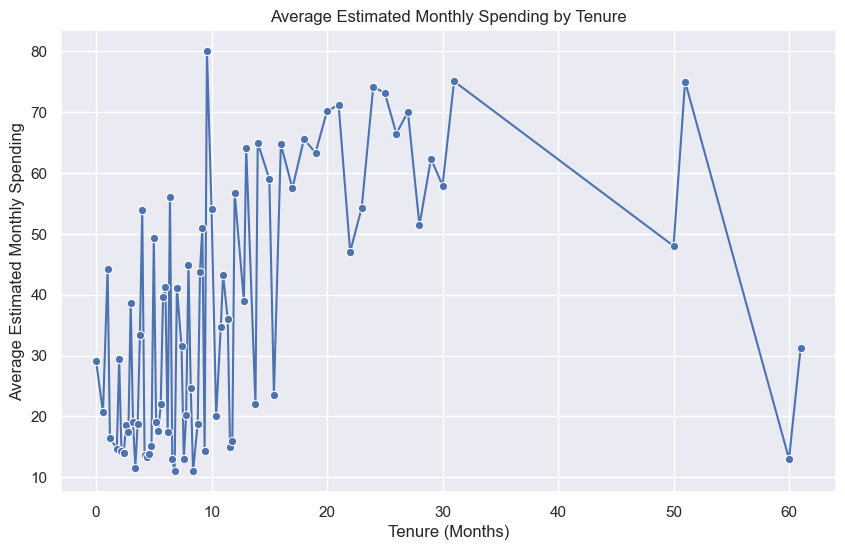

In [17]:
ecom['EstimatedMonthlySpending'] = ecom['OrderCount'] * ecom['OrderAmountHikeFromlastYear']
tenure_spending_avg = ecom.groupby('Tenure')['EstimatedMonthlySpending'].mean().reset_index()

plt.figure(figsize = (10,6))
sns.lineplot(data = tenure_spending_avg, x = 'Tenure', y = 'EstimatedMonthlySpending', marker = 'o')
plt.title('Average Estimated Monthly Spending by Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Average Estimated Monthly Spending')
plt.show()


- The graph shows that the estimated monthly spending doesn't have any impact on tenure.

**Churn by Satisfaction Score**

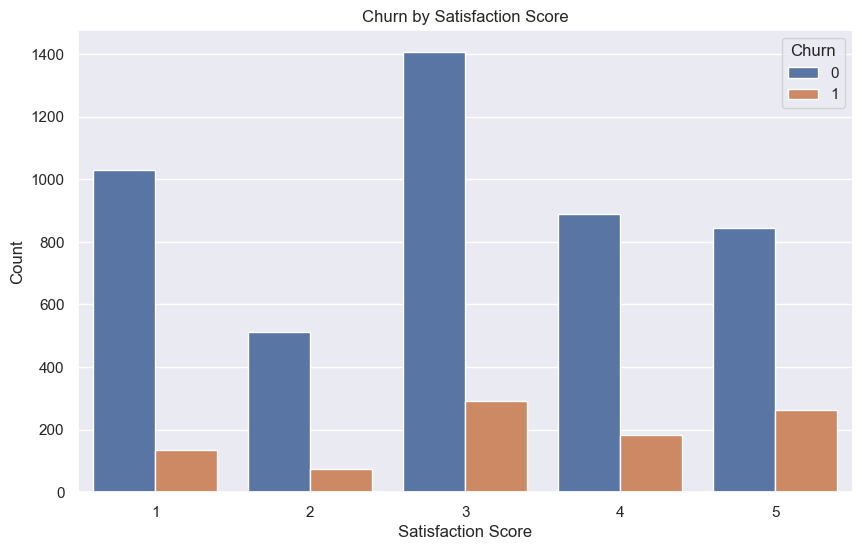

In [18]:
plt.figure(figsize = (10,6))
sns.countplot(data = ecom, x = 'SatisfactionScore', hue = 'Churn')
plt.title('Churn by Satisfaction Score')
plt.xlabel('Satisfaction Score')
plt.ylabel('Count')
plt.legend(title = 'Churn')
plt.show()

- Satisfaction Score has no effect on Customer Churn  since the percentage of churned customers is similar by comparing bar heights.

**Order Amount Hike by City Tier and Satisfaction Score**

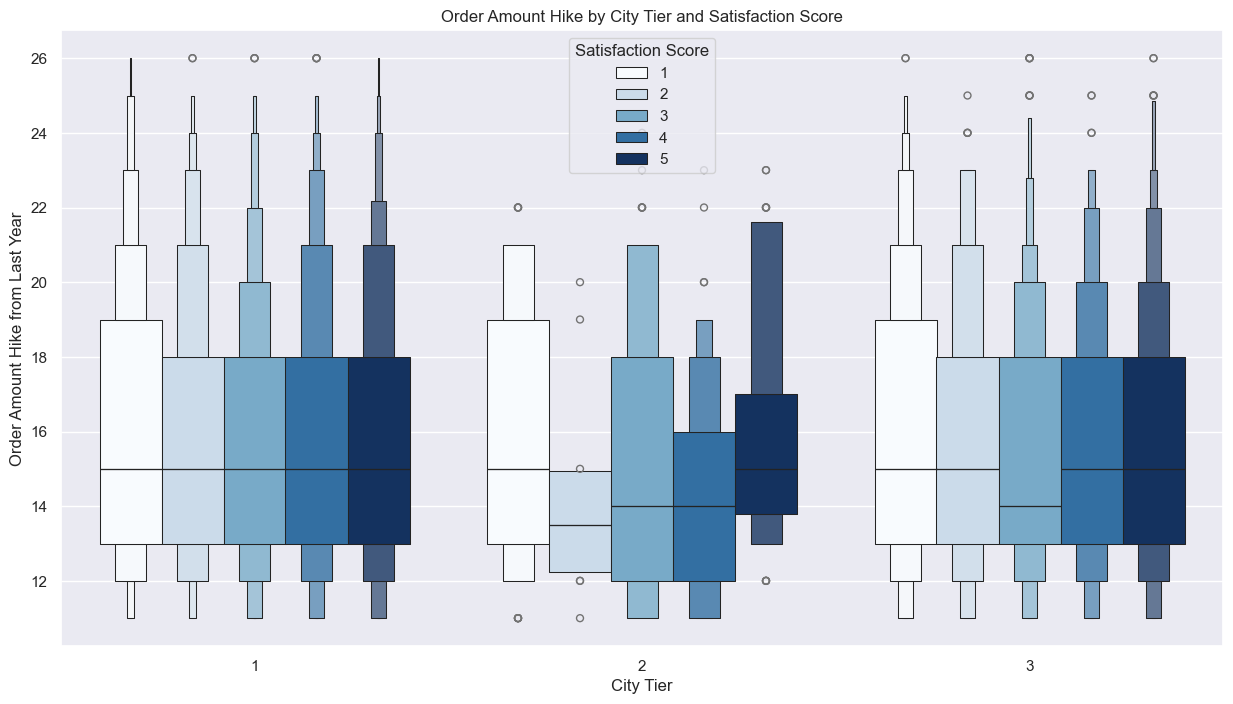

In [19]:
plt.figure(figsize=(15,8))
sns.boxenplot(data=ecom, x='CityTier', y='OrderAmountHikeFromlastYear', hue='SatisfactionScore', palette='Blues')
plt.title('Order Amount Hike by City Tier and Satisfaction Score')
plt.xlabel('City Tier')
plt.ylabel('Order Amount Hike from Last Year')
plt.legend(title='Satisfaction Score', loc = "upper center")
plt.show()

- The order amount hike is equally distributed for all satisfaction scores for cities 1 and 3.
- In city tier 2 people with low satisfaction scores tend to have a lower order amount hike compared to people with good satisfaction scores.
- This implies that the company could concentrate on customers in city tier 2 by giving more offers and discounts.

**Pairplot of Continuous Variables by Churn Status**

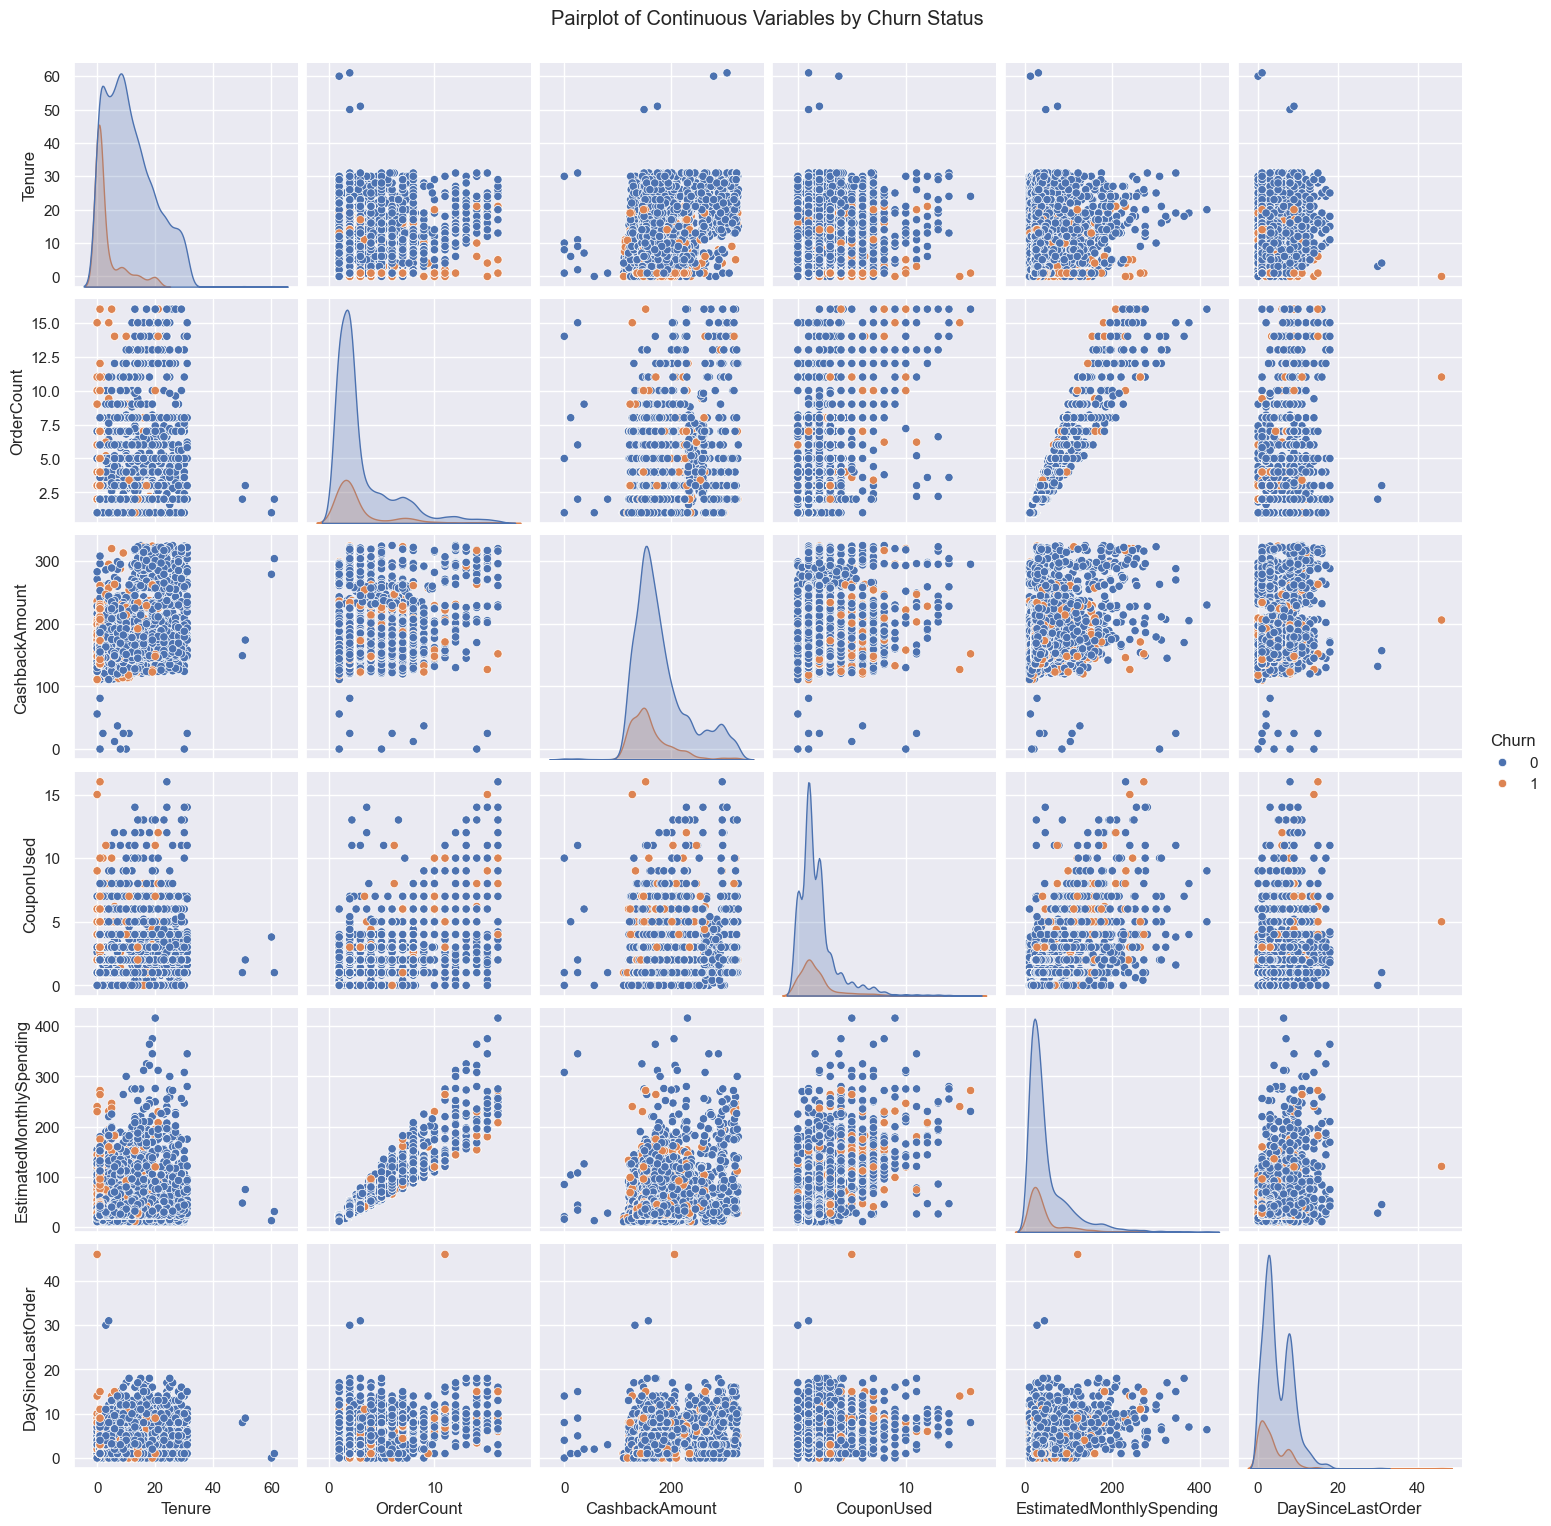

In [20]:
sns.pairplot(ecom, vars=['Tenure', 'OrderCount', 'CashbackAmount', 'CouponUsed','EstimatedMonthlySpending', 'DaySinceLastOrder'], hue = 'Churn')
plt.suptitle('Pairplot of Continuous Variables by Churn Status', y = 1.02)
plt.show()

In [21]:
ecom.corr()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,EstimatedMonthlySpending
CustomerID,1.000000,-0.019083,0.050703,0.003239,0.061548,0.603146,0.411098,-0.033146,0.160814,-0.009944,0.123574,0.236334,0.137242,0.118381,0.217173,0.156947
Churn,-0.019083,1.000000,-0.340333,0.084703,0.070135,0.014232,0.107939,0.105481,0.043931,0.250188,-0.014092,-0.011395,-0.036413,-0.154010,-0.154161,-0.042793
Tenure,0.050703,-0.340333,1.000000,-0.051261,-0.015125,0.009558,-0.014516,-0.013632,0.240419,-0.018493,0.017388,0.150077,0.210519,0.193992,0.483951,0.205883
CityTier,0.003239,0.084703,-0.051261,1.000000,0.013338,-0.001496,0.027934,-0.011554,-0.029440,0.003375,-0.031263,0.021853,0.029597,0.023470,0.055698,0.036298
WarehouseToHome,0.061548,0.070135,-0.015125,0.013338,1.000000,0.065658,0.022410,0.007994,-0.008228,0.027536,0.040357,0.002847,0.011055,0.018145,-0.003837,0.016258
HourSpendOnApp,0.603146,0.014232,0.009558,-0.001496,0.065658,1.000000,0.322235,0.030820,0.153634,0.009824,0.109748,0.192609,0.113523,0.091777,0.146472,0.125718
NumberOfDeviceRegistered,0.411098,0.107939,-0.014516,0.027934,0.022410,0.322235,1.000000,-0.017228,0.084997,0.003407,0.072436,0.148421,0.097007,0.024820,0.137396,0.104464
SatisfactionScore,-0.033146,0.105481,-0.013632,-0.011554,0.007994,0.030820,-0.017228,1.000000,0.053583,-0.031115,-0.030101,0.015781,0.019371,0.025894,0.003429,0.011703
NumberOfAddress,0.160814,0.043931,0.240419,-0.029440,-0.008228,0.153634,0.084997,0.053583,1.000000,-0.026399,0.019608,0.047904,0.004748,-0.057574,0.186802,0.004994
Complain,-0.009944,0.250188,-0.018493,0.003375,0.027536,0.009824,0.003407,-0.031115,-0.026399,1.000000,-0.004951,-0.006605,-0.013751,-0.041405,0.000598,-0.010234


- `CouponUsed` and `OrderCount` have a better correlation than any other features in the original data which doesn't provide any insights.
- Rest all features have a very lower correlation score with other variables.
- The made up column `EstimatedMonthlySpending` have a better correlation with all other variables in the dataset.

### Modelling

**Preprocessing**

In [39]:
x = ecom.drop(columns = ["CustomerID", "Churn", "EstimatedMonthlySpending", "TenureRange"])
X = pd.get_dummies(x, drop_first = True)
y = ecom["Churn"]

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

**Logistic Regression**

In [41]:
log = LogisticRegression(random_state = 123)
log.fit(x_train, y_train)

LogisticRegression(random_state=123)

In [42]:
y_pred_train = log.predict(x_train)
y_pred_test = log.predict(x_test)

In [43]:
# Classification Report - Training 

print(classification_report(y_train, y_pred_train))

print()
print()

# Classification Report - Testing 

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      3744
           1       0.74      0.50      0.60       760

    accuracy                           0.89      4504
   macro avg       0.82      0.73      0.77      4504
weighted avg       0.88      0.89      0.88      4504



              precision    recall  f1-score   support

           0       0.91      0.96      0.93       938
           1       0.73      0.50      0.59       188

    accuracy                           0.89      1126
   macro avg       0.82      0.73      0.76      1126
weighted avg       0.88      0.89      0.88      1126



<Axes: >

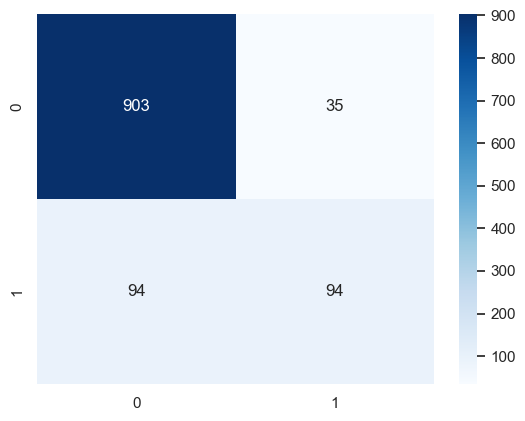

In [44]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot = True, fmt = ".5g", cmap = "Blues")

**Decision Tree**

In [45]:
dt = DecisionTreeClassifier(random_state = 123)
dt.fit(x_train, y_train)

DecisionTreeClassifier(random_state=123)

In [46]:
y_pred_train = dt.predict(x_train)
y_pred_test = dt.predict(x_test)

In [47]:
# Classification Report - Training 

print(classification_report(y_train, y_pred_train))

print()
print()

# Classification Report - Testing 

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3744
           1       1.00      1.00      1.00       760

    accuracy                           1.00      4504
   macro avg       1.00      1.00      1.00      4504
weighted avg       1.00      1.00      1.00      4504



              precision    recall  f1-score   support

           0       0.97      0.97      0.97       938
           1       0.86      0.86      0.86       188

    accuracy                           0.95      1126
   macro avg       0.91      0.92      0.92      1126
weighted avg       0.95      0.95      0.95      1126



<Axes: >

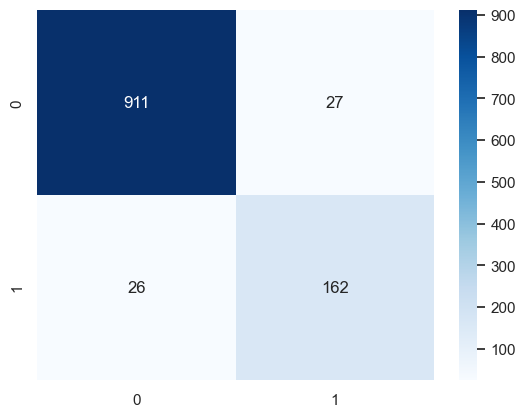

In [48]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot = True, fmt = ".5g", cmap = "Blues")

**Random Forest**

In [57]:
rf = RandomForestClassifier(n_estimators = 50, random_state = 123)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=123)

In [58]:
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)

In [59]:
# Classification Report - Training 

print(classification_report(y_train, y_pred_train))

print()
print()

# Classification Report - Testing 

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3744
           1       1.00      1.00      1.00       760

    accuracy                           1.00      4504
   macro avg       1.00      1.00      1.00      4504
weighted avg       1.00      1.00      1.00      4504



              precision    recall  f1-score   support

           0       0.96      1.00      0.98       938
           1       0.97      0.81      0.89       188

    accuracy                           0.97      1126
   macro avg       0.97      0.90      0.93      1126
weighted avg       0.97      0.97      0.96      1126



<Axes: >

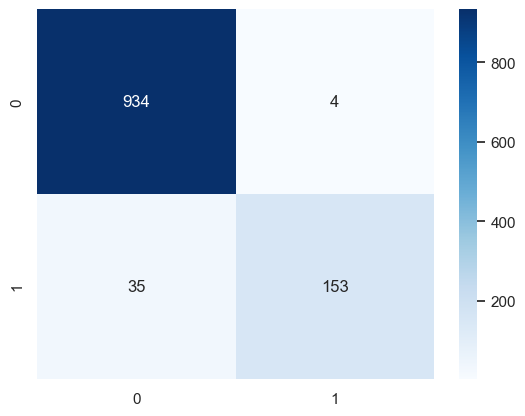

In [61]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot = True, fmt = ".5g", cmap = "Blues")

- Logistic model is undefitting while Decision tree is overfitting.
- Random Forest has a better metric score compared to other models.

In [62]:
# Predicting the whole dataset using the model
Y_pred = rf.predict(X)

In [63]:
# Creating a dataset with customers corresponding to the predictions
new_df = pd.concat((ecom['CustomerID'], pd.Series(Y_pred)), axis = 1)
new_df.columns = ["CustomerID", "Churn"]
new_df.head()

,CustomerID,Churn
0,50001,1
1,50002,1
2,50003,1
3,50004,1
4,50005,1


In [64]:
new_df[new_df['Churn'] == 1]

,CustomerID,Churn
0,50001,1
1,50002,1
2,50003,1
3,50004,1
4,50005,1
...,...,...
5556,55557,1
5598,55599,1
5602,55603,1
5604,55605,1


- Based on the model 917 customers from the whole dataset with the given corresponding ID's are likely to Churn in the future.

### Marketing Strategy
- **During our analysis we found that most customers are leaving at the first few months of the service tenure. These customers churned maybe because they found a better alternative to what the company was already offering. A better understanding of the competitora as well as providing attractive offers to new customers can be a way to improve retention.**
- **Actively seeking feedback from customers who leave early as well as concentrating on providing flexible plans to cities where the customer satisfaction scores are low can be also implemented to reduce churn.**
- **Implementing regular follow-up to customers who recently joined can improve their perspective of the company as well as motivate them to refer others.**